In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from RF_Shap import RFShap
import time


In [2]:
data_dir = '/home/matthewvowels/GitHub/Psych_ML/Shapley_Forest/'
file = 'simple_dataset.csv'

dataset = pd.read_csv(os.path.join(data_dir, file), delim_whitespace=False)
cols = dataset.columns

dataset = dataset.iloc[:100]

# # make it a multiclass problem by hypothetically extending 'male' var to have three genders
# dataset['male'] = dataset.male + np.random.randint(2, size=(len(dataset)))
# dataset.head()

In [3]:
od = '/home/matthewvowels/GitHub/Psych_ML/Shapley_Forest/output'
model_dir = '/home/matthewvowels/GitHub/Psych_ML/Shapley_Forest/output/model.sav'

# Created RFShap Class/environment:
shap_env = RFShap(model_dir=model_dir, exclude_vars=None, outcome_var='male',
                  output_dir=od, random_seed=42, class_='RF',type_='cls', balanced='balanced',
                 trn_tst_split=0.6, k_cv='k_fold', k=5)

# Feed in desired dataset. This removes exclude_vars, and splits into X, y,
# as well as making train test splits
dataset, X, y, xtr, xts, ytr, ytst  = shap_env.munch(dataset=dataset)


Preparing dataset...
Check if continuous or categorical variables: 
{'age': False, 'children': True, 'male': True, 'female': True, 'ftm': True, 'mtf': True, 'straight': True, 'gay': True, 'lesbian': True}


In [4]:
# here is a list of possible config settings for each classifier (we are using config_cls for 
# a random forest classifier)

config_reg = {'n_estimators': 200, 'criterion': 'mse', 'max_depth': None, 'min_samples_split': 2,
          'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto',
          'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None,
          'bootstrap': True, 'oob_score': True, 'n_jobs': None, 'random_state': None, 
          'verbose': 0, 'warm_start': False, 'max_samples': None}

config_cls = {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2,
          'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto',
          'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 
          'bootstrap': True, 'oob_score': True, 'n_jobs': None, 'random_state': None, 
          'verbose': 0, 'warm_start': False, 'max_samples': None}

config_linreg = {'fit_intercept': True, 'normalize': False, 'n_jobs': None}


config_logreg = {'penalty': 'l2', 'dual': False, 'tol': 1e-4, 'C': 1.0, 'fit_intercept': True,
                'intercept_scaling': 1.0, 'solver': 'lbfgs', 'class_weight': None, 'max_iter': 100, 'multi_class': 'auto',
                'verbose': 0, 'n_jobs': None}


# init a model with the config settings:
model = shap_env.make_model(config=config_cls)

# # decide one some tunable parameters (we are using tunable_params_rf because we have a RF classifier)
# tunable_params_rf = ['n_estimators', 'max_depth', 'max_features']
# tunable_params_linreg = ['normalize', 'fit_intercept']
# tunable_params_logreg = ['penalty', 'dual', 'tol', 'C', 'fit_intercept', 'solver', 'max_iter']

# # tunable_params_rf = ['max_depth'] 
# # identify some good hyperparameters by doing a random search:
# tuned_model = shap_env.tune_model(tunable_params=tunable_params_rf, folds=5, n_iter=100) 

# now we need to train the model:
model, report = shap_env.train_test()

# models can be saved and loaded like this (it uses the previously set model_dir, but you can
# also set a new one as an arugment if you wish!)
shap_env.save_model()
model = shap_env.load_model()

Creating fresh model...
Created:  BalancedRandomForestClassifier(n_estimators=200, oob_score=True)
Training fold:  1
Creating fresh model...
Created:  BalancedRandomForestClassifier(n_estimators=200, oob_score=True)


Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


Training fold:  2
Creating fresh model...
Created:  BalancedRandomForestClassifier(n_estimators=200, oob_score=True)
Training fold:  3
Creating fresh model...
Created:  BalancedRandomForestClassifier(n_estimators=200, oob_score=True)
Training fold:  4
Creating fresh model...
Created:  BalancedRandomForestClassifier(n_estimators=200, oob_score=True)
Training fold:  5
Creating fresh model...
Created:  BalancedRandomForestClassifier(n_estimators=200, oob_score=True)
   class   pre   rec   spe    f1   geo   iba   sup  fold
0    0.0  1.00  0.88  1.00  0.94  0.94  0.87  17.0     1
1    1.0  0.60  1.00  0.88  0.75  0.94  0.89   3.0     1
0    0.0  1.00  0.92  1.00  0.96  0.96  0.91  12.0     2
1    1.0  0.89  1.00  0.92  0.94  0.96  0.92   8.0     2
0    0.0  1.00  0.86  1.00  0.92  0.93  0.84  14.0     3
1    1.0  0.75  1.00  0.86  0.86  0.93  0.87   6.0     3
0    0.0  1.00  0.92  1.00  0.96  0.96  0.92  13.0     4
1    1.0  0.88  1.00  0.92  0.93  0.96  0.93   7.0     4
0    0.0  1.00  0.8

In [5]:
# now we have a trained model with reasonably good training parameters we can do some interpretation
# this first bit creates and saves the output of the Shap explainer:
explainer, shap_vals = shap_env.run_shap_explainer(model=model)

Running Shap Explainer.


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


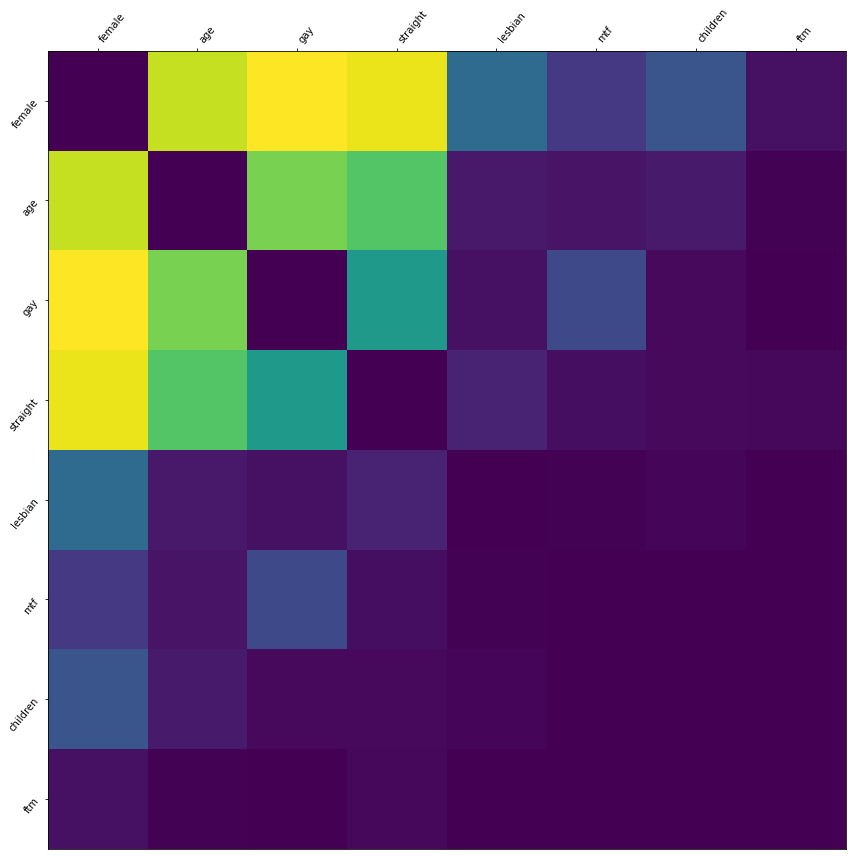

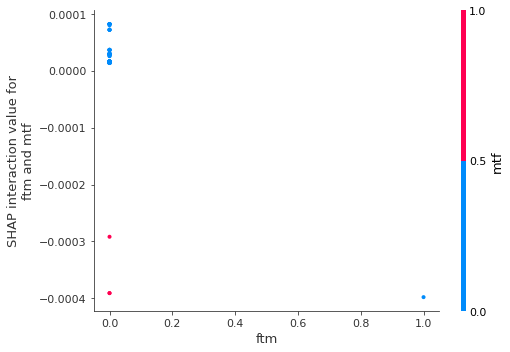

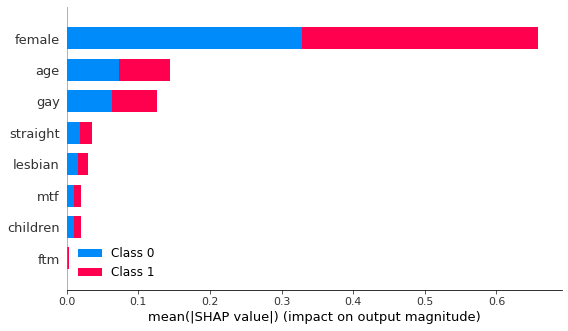

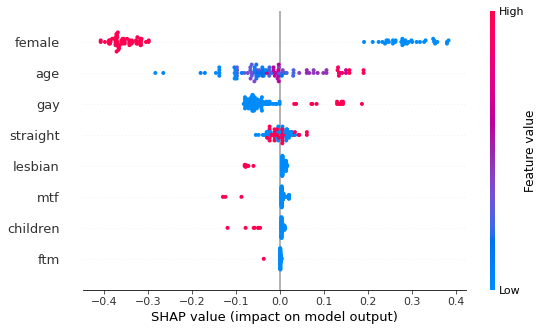

In [6]:
specific_var = None
num_disp = 10  # plots the top `num_disp' features
interaction_vars = ['ftm', 'mtf']
# to create plots (and automatrically save them to the output directory):
interaction_vals = shap_env.shap_plot(explainer=explainer, shap_vals=shap_vals, specific_var=specific_var, interactions=True, interaction_vars=interaction_vars, classwise=True, class_ind=1, num_display=num_disp)             
